In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import seaborn as sns
import pandas as pd

import cv2
import os
import time
import tensorflow.keras.layers as l
%matplotlib inline


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
   # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs,


In [3]:
def showKeypoints(img,kps):
    plt.imshow(img)
    kps = np.reshape(kps,(-1,2))
    plt.scatter(kps[:,0],kps[:,1],s=4,c='red')
    plt.show()

In [16]:
class DataGen:
    def __init__(self,csv,dir_,target_size,batch):
        self.csv = csv
        self.dir = dir_
        self.df = pd.read_csv(self.csv)
        self.batch =batch
        self.target_size = target_size
        self.images = np.array(self.df.iloc[:,0]) 
        self.kps = np.array(self.df.iloc[:,1:])
        self.length = self.images.shape[0]
        
    def rescale(self,sample):
        
        size = self.target_size[0]+50,self.target_size[1]+50
        img = sample["img"]
        kps = sample["kps"]
        
        h,w = img.shape[:2]
        if isinstance(size, int):
            if h > w:
                new_h, new_w = size * h / w, size
            else:
                new_h, new_w = size, size * w / h
        else:
            new_h,new_w = size
        new_h,new_w = int(new_h),int(new_w)
        new_im = cv2.resize(img,(new_h,new_w))
        new_kps = kps * [new_w / w, new_h / h]
        
        return {"img": new_im,"kps":new_kps}
        
    def random_crop(self,sample):
        
        h,w = self.target_size
        image, key_pts = sample['img'], sample['kps']

        im_h, im_w = image.shape[:2]
        

        top = np.random.randint(0,im_h - h)
        left = np.random.randint(0, im_w - w)

        image = image[top: top + h,
                      left: left + w]

        key_pts = key_pts - [left, top]

        return {'img': image, 'kps': key_pts}
    
    def normalize(self, sample):
        image, key_pts = sample['img'], sample['kps']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'img': image_copy, 'kps': key_pts_copy}
        
        

    def generate(self):
        
        while True:
            batch_in=[]
            batch_out=[]
            for i in range(self.batch):
                idx = np.random.randint(self.length)
            
                img_name = self.images[idx]
                img = cv2.imread(self.dir+img_name)
                
                key_points = self.kps[idx]
                key_points = key_points.astype('float').reshape(-1, 2)
                sample = {"img": img, "kps": key_points}
                # rescaling
                sample = self.rescale(sample)
                # random_cropping
                sample = self.random_crop(sample)
                   
                 # normalizing    
                sample = self.normalize(sample)
                img = np.expand_dims(sample["img"],2)
                kps = np.reshape(sample["kps"],(136,))
                batch_in.append(img)
                batch_out.append(kps)
            # batch
            batch_in = np.array(batch_in)
            batch_out = np.array(batch_out)
            
            
            
            yield batch_in,batch_out
        

In [17]:
test = DataGen("data/test.csv","data/test/",(96,96),2)

In [18]:
# Learning rate scheduler
def scheduler(epoch):
    
    if epoch>60:
        return 0.001*tf.math.exp(0.1*(60-60-epoch))
    else:
        return 0.001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [19]:
x= test.generate()

In [20]:
t,u = next(x) # un-normalized test sample 

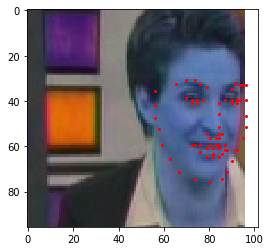

In [21]:
showKeypoints(t[0][:,:,0],u[0])

In [164]:

# LeNet model

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32,(5,5),input_shape=(96,96,1),data_format="channels_last"),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.MaxPool2D((2,2),2),
    
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Conv2D(64,(3,3)),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.MaxPool2D((2,2),2),
    
    tf.keras.layers.Dropout(0.2),
   
    tf.keras.layers.Conv2D(128,(3,3)),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.MaxPool2D((2,2),2),
    
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(256,(3,3)),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.MaxPool2D((2,2),2),
    
    tf.keras.layers.Dropout(0.4),
 
    tf.keras.layers.Conv2D(512,(1,1)),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.MaxPool2D((2,2),2),
    
  
    tf.keras.layers.Flatten(),
   
 
    tf.keras.layers.Dense(1024),
    tf.keras.layers.LeakyReLU(0.1),
    
    tf.keras.layers.Dropout(0.5),
 
    tf.keras.layers.Dense(1024),
    tf.keras.layers.LeakyReLU(0.1),

   
    tf.keras.layers.Dense(136,activation="linear")
    
    
    ])

In [221]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 92, 92, 32)        832       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 22, 64)       

In [22]:
train = DataGen("data/train.csv","data/training/",(96,96),64) # Training generator

In [ ]:
train_gen =train.generate() #

In [232]:
# Compiling with Adam
model.compile(optimizer =Adam,loss="mse",metrics=["acc"])

In [ ]:
# Training
history = model.fit(x,epochs=150,steps_per_epoch=54)

In [ ]:
plt.plot(history.history["loss"])
plt.show()

In [ ]:
model.save("saved_models/model")

In [23]:
# Testing saved model
model = tf.keras.models.load_model("saved_models/model")

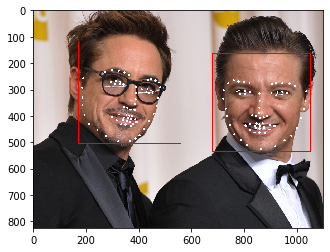

In [32]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


fr = cv2.imread("data/downey.jpg")		
fr = cv2.cvtColor(fr,cv2.COLOR_BGR2RGB)
im = fr.copy()
H,W,C = fr.shape
im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(im, 1.3, 5)
for (x,y,w,h) in faces:

    fr = cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = im[y:y+h, x:x+w]
			
    roi_gray = cv2.resize(roi_gray,(96,96))
			
    roi_gray = roi_gray/255
    H,W = roi_gray.shape
    roi_gray = np.expand_dims(roi_gray,0)
    roi_gray = np.expand_dims(roi_gray,3)
		
    res = model.predict(roi_gray)
		
    res = res*50+100
    res = np.reshape(res,(-1,2))
    res = res*[(w)/96,(h)/96]
    res = res+[x,y]
			
    for i in res:
        u,v = int(i[0]),int(i[1])
        cv2.circle(fr,(u,v),4,(255,255,255),-1)
plt.imshow(fr)
plt.show()